### Generating human faces with Adversarial Networks
[![img](https://www.strangerdimensions.com/wp-content/uploads/2013/11/reception-robot.jpg)](http://payload.cargocollective.com/1/0/17293/393670/HumanTaxidermy01.jpg)

This time we'll train a neural net to generate plausible human faces in all their subtlty: appearance, expression, accessories, etc. 'Cuz when us machines gonna take over Earth, there won't be any more faces left. We want to preserve this data for future iterations. Yikes...

Based on Based on https://github.com/Lasagne/Recipes/pull/94 .


In [1]:
import sys
sys.path.append("..")
import grading
import download_utils

In [2]:
def decode_image_from_raw_bytes(raw_bytes):
    img = cv2.imdecode(np.asarray(bytearray(raw_bytes), dtype=np.uint8), 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

In [3]:
import numpy as np
import os
import cv2
import pandas as pd
import tarfile
import tqdm


ATTRS_NAME = "lfw_attributes.txt"  # http://www.cs.columbia.edu/CAVE/databases/pubfig/download/lfw_attributes.txt
IMAGES_NAME = "lfw-deepfunneled.tgz"  # http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz
RAW_IMAGES_NAME = "lfw.tgz"  # http://vis-www.cs.umass.edu/lfw/lfw.tgz

use_raw=False
dx=80
dy=80
dimx=36
dimy=36

# read attrs
df_attrs = pd.read_csv(ATTRS_NAME, sep='\t', skiprows=1)
df_attrs = pd.DataFrame(df_attrs.iloc[:, :-1].values, columns=df_attrs.columns[1:])
imgs_with_attrs = set(map(tuple, df_attrs[["person", "imagenum"]].values))

# read photos
all_photos = []
photo_ids = []

with tarfile.open(RAW_IMAGES_NAME if use_raw else IMAGES_NAME) as f:
    for m in tqdm.tqdm_notebook(f.getmembers()):
        if m.isfile() and m.name.endswith(".jpg"):
            # prepare image
            img = decode_image_from_raw_bytes(f.extractfile(m).read())
            img = img[dy:-dy, dx:-dx]
            img = cv2.resize(img, (dimx, dimy))
            # parse person
            fname = os.path.split(m.name)[-1]
            fname_splitted = fname[:-4].replace('_', ' ').split()
            person_id = ' '.join(fname_splitted[:-1])
            photo_number = int(fname_splitted[-1])
            if (person_id, photo_number) in imgs_with_attrs:
                all_photos.append(img)
                photo_ids.append({'person': person_id, 'imagenum': photo_number})

photo_ids = pd.DataFrame(photo_ids)
all_photos = np.stack(all_photos).astype('uint8')


In [11]:
print(type(photo_ids['imagenum'][0]))
print(type(df_attrs['imagenum'][0]))
photo_ids['imagenum']=photo_ids['imagenum'].astype(int)
df_attrs['imagenum']=df_attrs['imagenum'].astype(int)
print(type(photo_ids['imagenum'][0]))
print(type(df_attrs['imagenum'][0]))

# preserve photo_ids order!
all_attrs = photo_ids.merge(df_attrs, on=('person', 'imagenum')).drop(["person", "imagenum"], axis=1)

<class 'numpy.int64'>
<class 'int'>
<class 'numpy.int32'>
<class 'numpy.int32'>


In [14]:
data,attrs = all_photos, all_attrs
#preprocess faces
data = np.float32(data)/255.

IMG_SHAPE = data.shape[1:]

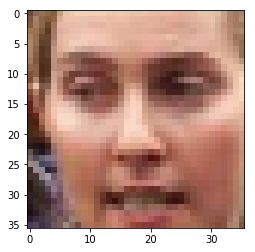

In [15]:
#print random image
plt.imshow(data[np.random.randint(data.shape[0])], cmap="gray", interpolation="none")

# Generative adversarial nets 101

<img src="https://raw.githubusercontent.com/torch/torch.github.io/master/blog/_posts/images/model.png" width=320px height=240px>

Deep learning is simple, isn't it? 
* build some network that generates the face (small image)
* make up a __measure__ of __how good that face is__
* optimize with gradient descent :)


The only problem is: how can we engineers tell well-generated faces from bad? And i bet you we won't ask a designer for help. 

__If we can't tell good faces from bad, we delegate it to yet another neural network!__

That makes the two of them:
* __G__enerator - takes random noize for inspiration and tries to generate a face sample. 
  * Let's call him __G__(z), where z is a gaussian noize.
* __D__iscriminator - takes a face sample and tries to tell if it's great or fake. 
  * Predicts the probability of input image being a __real face__
  * Let's call him __D__(x), x being an image.
  * __D(x)__ is a predition for real image and __D(G(z))__ is prediction for the face made by generator.

Before we dive into training them, let's construct the two networks.

In [16]:
import tensorflow as tf
gpu_options = tf.GPUOptions(allow_growth=True,per_process_gpu_memory_fraction=0.333)
s = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))

import keras
from keras.models import Sequential
from keras import layers as L

Using TensorFlow backend.


In [17]:
CODE_SIZE = 256

generator = Sequential()
generator.add(L.InputLayer([CODE_SIZE],name='noise'))
generator.add(L.Dense(10*8*8, activation='elu'))

generator.add(L.Reshape((8,8,10)))
generator.add(L.Deconv2D(64,kernel_size=(5,5),activation='elu'))
generator.add(L.Deconv2D(64,kernel_size=(5,5),activation='elu'))
generator.add(L.UpSampling2D(size=(2,2)))
generator.add(L.Deconv2D(32,kernel_size=3,activation='elu'))
generator.add(L.Deconv2D(32,kernel_size=3,activation='elu'))
generator.add(L.Deconv2D(32,kernel_size=3,activation='elu'))

generator.add(L.Conv2D(3,kernel_size=3,activation=None))


In [18]:
assert generator.output_shape[1:] == IMG_SHAPE, "generator must output an image of shape %s, but instead it produces %s"%(IMG_SHAPE,generator.output_shape[1:])

In [20]:
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 640)               164480    
_________________________________________________________________
reshape_1 (Reshape)          (None, 8, 8, 10)          0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 12, 12, 64)        16064     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 16, 16, 64)        102464    
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 34, 34, 32)        18464     
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 36, 36, 32)        9248      
__________

### Discriminator
* Discriminator is your usual convolutional network with interlooping convolution and pooling layers
* The network does not include dropout/batchnorm to avoid learning complications.
* We also regularize the pre-output layer to prevent discriminator from being too certain.

In [23]:
discriminator = Sequential()

discriminator.add(L.InputLayer(IMG_SHAPE))

discriminator.add(L.Conv2D(filters=64, kernel_size=(3, 3), activation='elu', padding='same'))
discriminator.add(L.Conv2D(filters=64, kernel_size=(3, 3), activation='elu', padding='same'))
discriminator.add(L.MaxPooling2D(pool_size=(2, 2), padding='same'))

discriminator.add(L.Conv2D(filters=64, kernel_size=(3, 3), activation='elu', padding='same'))
discriminator.add(L.Conv2D(filters=32, kernel_size=(3, 3), activation='elu', padding='same'))
discriminator.add(L.MaxPooling2D(pool_size=(2, 2), padding='same'))

discriminator.add(L.Conv2D(filters=32, kernel_size=(3, 3), activation='elu', padding='same'))
discriminator.add(L.Conv2D(filters=32, kernel_size=(3, 3), activation='elu', padding='same'))
discriminator.add(L.MaxPooling2D(pool_size=(2, 2), padding='same'))


discriminator.add(L.Flatten())
discriminator.add(L.Dense(256,activation='tanh'))
discriminator.add(L.Dense(2,activation=tf.nn.log_softmax))


In [24]:
discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 36, 36, 64)        1792      
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 36, 36, 64)        36928     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 18, 18, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 18, 18, 64)        36928     
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 18, 18, 32)        18464     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 9, 9, 32)          0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 9, 9, 32)          9248      
__________

# Training

We train the two networks concurrently:
* Train __discriminator__ to better distinguish real data from __current__ generator
* Train __generator__ to make discriminator think generator is real
* Since discriminator is a differentiable neural network, we train both with gradient descent.

![img](https://s24.postimg.org/cw4nognxx/gan.png)

Training is done iteratively until discriminator is no longer able to find the difference (or until you run out of patience).


### Tricks:
* Regularize discriminator output weights to prevent explosion
* Train generator with __adam__ to speed up training. Discriminator trains with SGD to avoid problems with momentum.
* More: https://github.com/soumith/ganhacks


In [28]:
noise = tf.placeholder('float32',[None,CODE_SIZE])
real_data = tf.placeholder('float32',[None,]+list(IMG_SHAPE))

logp_real = discriminator(real_data)

generated_data = generator(noise)

logp_gen = discriminator(generated_data)


In [29]:
########################
#discriminator training#
########################

d_loss = -tf.reduce_mean(logp_real[:,1] + logp_gen[:,0])

#regularize
d_loss += tf.reduce_mean(discriminator.layers[-1].kernel**2)

#optimize
disc_optimizer =  tf.train.GradientDescentOptimizer(1e-3).minimize(d_loss,var_list=discriminator.trainable_weights)

In [30]:
########################
###generator training###
########################

g_loss = -tf.reduce_mean(logp_gen[:,1])

gen_optimizer = tf.train.AdamOptimizer(1e-4).minimize(g_loss,var_list=generator.trainable_weights)

    

In [31]:
s.run(tf.global_variables_initializer())

### Auxiliary functions
Here we define a few helper functions that draw current data distributions and sample training batches.

In [32]:
def sample_noise_batch(bsize):
    return np.random.normal(size=(bsize, CODE_SIZE)).astype('float32')

def sample_data_batch(bsize):
    idxs = np.random.choice(np.arange(data.shape[0]), size=bsize)
    return data[idxs]

def sample_images(nrow,ncol, sharp=False):
    images = generator.predict(sample_noise_batch(bsize=nrow*ncol))
    if np.var(images)!=0:
        images = images.clip(np.min(data),np.max(data))
    for i in range(nrow*ncol):
        plt.subplot(nrow,ncol,i+1)
        if sharp:
            plt.imshow(images[i].reshape(IMG_SHAPE),cmap="gray", interpolation="none")
        else:
            plt.imshow(images[i].reshape(IMG_SHAPE),cmap="gray")
    plt.show()

def sample_probas(bsize):
    plt.title('Generated vs real data')
    plt.hist(np.exp(discriminator.predict(sample_data_batch(bsize)))[:,1],
             label='D(x)', alpha=0.5,range=[0,1])
    plt.hist(np.exp(discriminator.predict(generator.predict(sample_noise_batch(bsize))))[:,1],
             label='D(G(z))',alpha=0.5,range=[0,1])
    plt.legend(loc='best')
    plt.show()

### Training
Main loop.
We just train generator and discriminator in a loop and plot results once every N iterations.

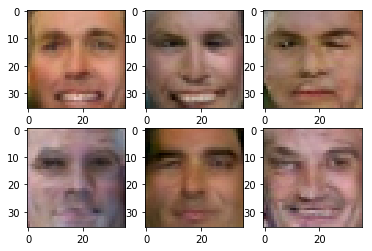

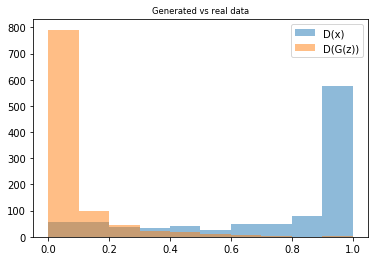

In [33]:
from IPython import display
from tqdm import tnrange

for epoch in tnrange(50000):
    
    feed_dict = {
        real_data:sample_data_batch(100),
        noise:sample_noise_batch(100)
    }
    
    for i in range(5):
        s.run(disc_optimizer,feed_dict)
    
    s.run(gen_optimizer,feed_dict)
    
    if epoch %100==0:
        display.clear_output(wait=True)
        sample_images(2,3,True)
        sample_probas(1000)
        

In [35]:
from submit_honor import submit_honor
submit_honor((generator, discriminator), 'whisper4738@gmail.com', 'DAztLRPK82LRzb9l')

Submitted to Coursera platform. See results on assignment page!


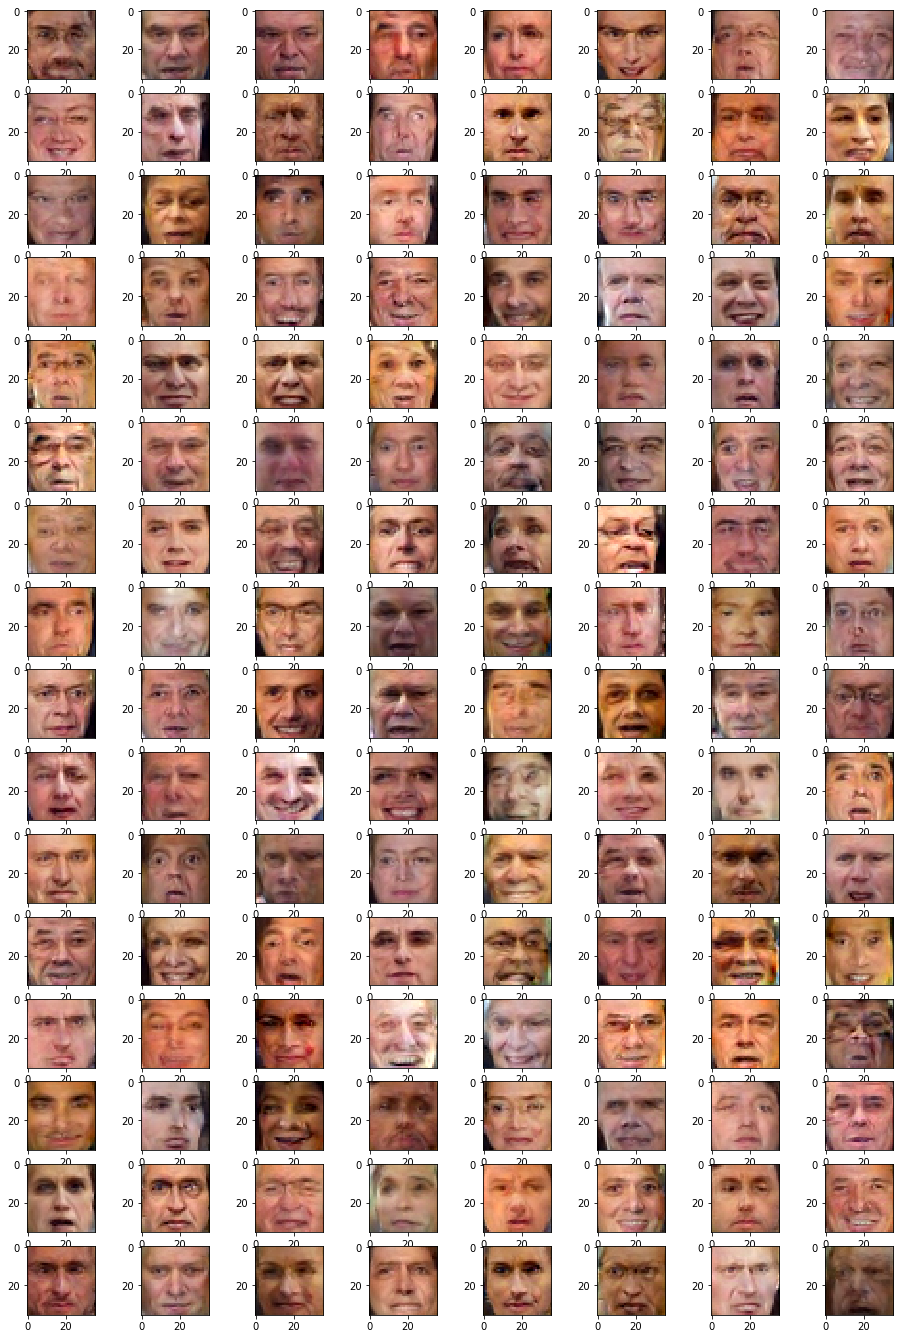

In [36]:
#The network was trained for about 15k iterations. 
#Training for longer yields MUCH better results
plt.figure(figsize=[16,24])
sample_images(16,8)